In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons

import scipy

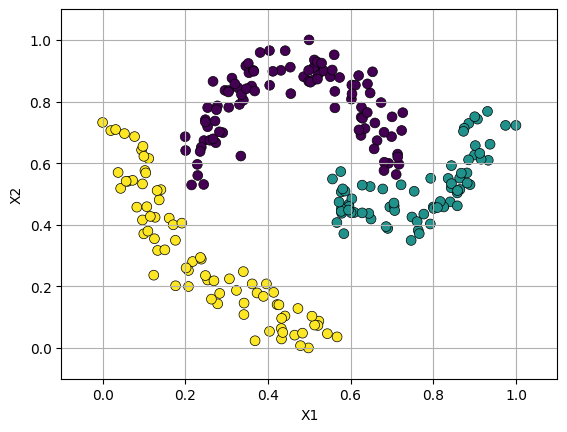

In [2]:
np.random.seed(249) ## 148, 249

xxc, yc = make_circles(n_samples=600, factor=.5,
                                      noise=.09)
idx = yc==0
xxc = xxc[idx]
yc = yc[idx]

idx = (xxc[:,0]+xxc[:,1]<-1)
xxc = xxc[idx]
yc = yc[idx]


xxm, ym = make_moons(n_samples=200, noise=.15)
xxm = xxm/2 - 0.2

msk0 = np.bitwise_and(ym==1 ,xxm[:, 0] > 0)
msk1 = ym==0
msk = msk0 | msk1
xxm = xxm[msk]
ym = ym[msk]

xx = np.concatenate((xxm, xxc), axis=0)
y = np.concatenate((ym, yc+2), axis=0)

## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
x1 = (x1-x1.min())/(x1.max()-x1.min())
x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

(x1min, x1max) = -0.1, 1.1
plt.xlim((x1min, x1max))
plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [3]:
# xx = np.random.randn(100, 2)

## Clustering

In [4]:
class GMM:
    def __init__(self, n_components):
        self.n_components = n_components
        self.pi = np.array([1/self.n_components for comp in range(self.n_components)])
        self.mean = None
        self.cov = None
        
    def multivariate_normal(self, X, mean, covariance):
        return scipy.stats.multivariate_normal.pdf(X, mean, covariance)
        
    def fit(self, X):
        new_X = np.array_split(X, self.n_components)
        self.mean = np.array([np.mean(x, axis=0) for x in new_X])
        self.cov = np.array([np.cov(x.T) for x in new_X])
        # Deleting the new_X matrix because we will not need it anymore
        del new_X
        
            
    def predict(self, X, rescale=False):
        probas = np.zeros((len(X), self.n_components))
        for k in range(self.n_components):
            if rescale:
                probas[:, k] = self.pi[k] * self.multivariate_normal(X, self.mean[k], self.cov[k])
            else:
                probas[:, k] = self.multivariate_normal(X, self.mean[k], self.cov[k])
        return np.argmax(probas, axis=1)

In [5]:
# np.random.seed(258)
xx = np.random.randn(100, 2)

In [6]:
gmm = GMM(3)

In [7]:
gmm.fit(xx)

In [8]:
gmm.mean

array([[ 0.41453457,  0.19979812],
       [-0.08111267,  0.25202402],
       [ 0.00178983, -0.01557289]])

In [9]:
gmm.cov

array([[[ 0.86648846,  0.29901996],
        [ 0.29901996,  1.15730383]],

       [[ 0.97932611, -0.03501753],
        [-0.03501753,  1.03983903]],

       [[ 0.5394324 , -0.11226725],
        [-0.11226725,  1.24076166]]])

## Now set means and cov and visualize decision boundary and contours

In [10]:
def plot_results(X, Y_, means, covariances, alpha=0.2, covar_scale = [0.5, 1, 2] ):
    ax = plt.subplot(1, 1, 1)
    for i, (mean, covar) in enumerate(zip(
            means, covariances)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        sctp = plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], marker='.')

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        c = sctp.get_facecolor()[0]
    
        for scale in covar_scale:
            ell = matplotlib.patches.Ellipse(mean, v[0]*scale, v[1]*scale, angle=180. + angle, color=c)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(alpha/scale)
            ax.add_artist(ell)

In [11]:
gmmc = gmm.predict(xx, rescale=False)

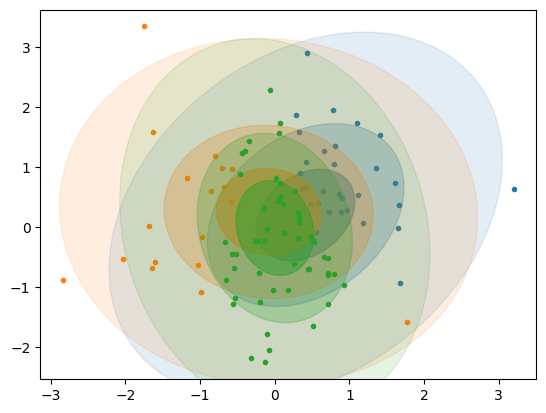

In [12]:
plot_results(xx, gmmc, gmm.mean, gmm.cov, alpha=0.25)

In [13]:
h = 2000
_xx, _yy = np.meshgrid(np.linspace(-5, 5, h), np.linspace(-5, 5, h))
xxyy = np.c_[_xx.ravel(), _yy.ravel()]

x1, x2 = xxyy[:, 0], xxyy[:, 1]

In [14]:
xxyy.shape

(4000000, 2)

In [15]:
out = gmm.predict(xxyy, rescale=False)

In [16]:
np.unique(out)

array([0, 1, 2])

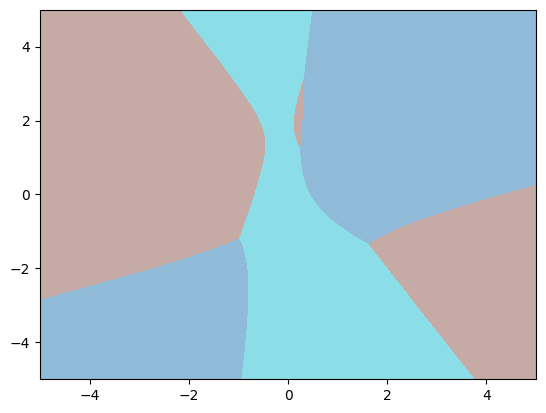

In [17]:
plt.imshow(out.reshape(_xx.shape), interpolation='nearest',
           extent=(_xx.min(), _xx.max(), _yy.min(), _yy.max()),
           cmap='tab10',
           alpha=0.5,
           aspect='auto', origin='lower')

# plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1), marker='*')
# plot_results(xx, gmmc, gmm.mean, gmm.cov, alpha=0.25)

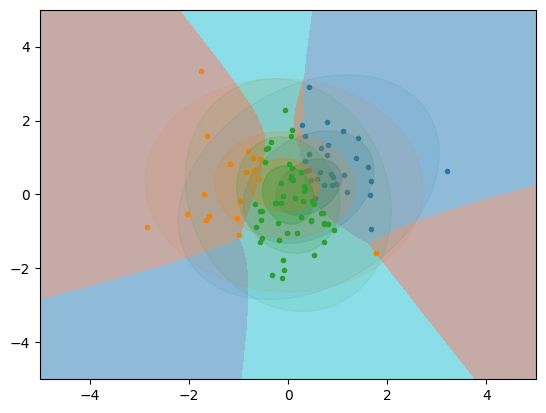

In [18]:
plt.imshow(out.reshape(_xx.shape), interpolation='nearest',
           extent=(_xx.min(), _xx.max(), _yy.min(), _yy.max()),
           cmap='tab10',
           alpha=0.5,
           aspect='auto', origin='lower')

# plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1), marker='*')
plot_results(xx, gmmc, gmm.mean, gmm.cov, alpha=0.15)